In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.metrics import roc_curve, accuracy_score, precision_score, recall_score, f1_score, auc
import matplotlib.pyplot as plt
from transformers import HubertModel, AutoProcessor
from tqdm import tqdm
import pickle
import torchvision.models as models

In [2]:
class LayerFeatureDataset(Dataset):
    def __init__(self, pkl_path):
        data = pickle.load(open(pkl_path, 'rb'))
        self.X = torch.tensor(data['features'], dtype=torch.float32)  
        self.y = torch.tensor(data['labels'],   dtype=torch.long)    
    def __len__(self):
        return len(self.y)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

class LayerWeightedAggregator(nn.Module):
    def __init__(self, num_layers):
        super().__init__()
        self.w = nn.Parameter(torch.ones(num_layers) / num_layers)
    def forward(self, x):
        w = torch.softmax(self.w, dim=0)             
        return (x * w[None, :, None]).sum(dim=1)

class ResNetClassifier(nn.Module):
    def __init__(self, num_layers, hidden_dim, num_classes):
        super().__init__()
        self.agg = LayerWeightedAggregator(num_layers)
        H = W = int(np.sqrt(hidden_dim))
        assert H*W == hidden_dim, "hidden_dim must be square"
        self.H, self.W = H, W

        self.resnet = models.resnet18(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1,
            self.resnet.conv1.out_channels,
            kernel_size=self.resnet.conv1.kernel_size,
            stride=self.resnet.conv1.stride,
            padding=self.resnet.conv1.padding,
            bias=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.agg(x)               
        b = x.size(0)
        x = x.view(b, 1, self.H, self.W)
        return self.resnet(x)


In [3]:
class DeepfakeDataset(Dataset):
    def __init__(self, data_dict):
        self.features = torch.tensor(data_dict["features"], dtype=torch.float32)
        self.labels = torch.tensor(data_dict["labels"], dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
        
class MaxFeatureMap1D(nn.Module):
    def forward(self, x):
        out = x.view(x.size(0), x.size(1) // 2, 2, x.size(2))
        out = out.max(dim=2)[0]
        return out

class DeepfakeClassifier(nn.Module):
    def __init__(self, input_dim=1024, hidden_dim=512, lstm_hidden_dim=256, num_classes=2):
        super(DeepfakeClassifier, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()

        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, stride=1, padding=2)
        self.mfm1 = MaxFeatureMap1D()  
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=1, stride=1)
        self.mfm2 = MaxFeatureMap1D()
        self.batchnorm1 = nn.BatchNorm1d(32)
        self.conv3 = nn.Conv1d(32, 96, kernel_size=3, stride=1, padding=1)
        self.mfm3 = MaxFeatureMap1D()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.batchnorm2 = nn.BatchNorm1d(48)
        self.conv4 = nn.Conv1d(48, 96, kernel_size=1, stride=1)
        self.mfm4 = MaxFeatureMap1D()
        self.batchnorm3 = nn.BatchNorm1d(48)
        self.conv5 = nn.Conv1d(48, 128, kernel_size=3, stride=1, padding=1)
        self.mfm5 = MaxFeatureMap1D()
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        
        self.lstm1 = nn.LSTM(input_size=64, hidden_size=lstm_hidden_dim, num_layers=1, 
                             bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=lstm_hidden_dim * 2, hidden_size=lstm_hidden_dim, num_layers=1, 
                             bidirectional=True, batch_first=True)

        self.gap = nn.AdaptiveAvgPool1d(1)

        self.fc2 = nn.Linear(lstm_hidden_dim * 2, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)

        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.mfm1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.mfm2(x)
        x = self.batchnorm1(x)
        x = self.conv3(x)
        x = self.mfm3(x)
        x = self.pool2(x)
        x = self.batchnorm2(x)
        x = self.conv4(x)
        x = self.mfm4(x)
        x = self.batchnorm3(x)
        x = self.conv5(x)
        x = self.mfm5(x)
        x = self.pool3(x)

        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)

        x = x.permute(0, 2, 1)
        x = self.gap(x).squeeze(-1)
        
        x = self.fc2(x)
        return x

In [4]:
def Train(model, optimizer, criterion, train_loader, val_loader, num_epochs=50):
    eer_per_epoch = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)

        model.eval()
        all_labels = []
        all_probs = []
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                probs = torch.softmax(outputs, dim=1)[:, 1]
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

        all_labels = np.array(all_labels)
        all_probs = np.array(all_probs)

        fpr, tpr, _ = roc_curve(all_labels, all_probs)
        fnr = 1 - tpr
        eer = fpr[np.nanargmin(np.abs(fpr - fnr))]
        eer_per_epoch.append(eer)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Val EER: {eer:.4f}")
        
    return eer_per_epoch

In [5]:
def Test(model, test_loader, name="Model"):
    model.eval()
    all_labels = []
    all_preds  = []
    all_probs  = []

    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)

            probs = torch.softmax(outputs, dim=1)[:, 1]
            preds = torch.argmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds  = np.array(all_preds)
    all_probs  = np.array(all_probs)

    accuracy  = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall    = recall_score(all_labels, all_preds)
    f1        = f1_score(all_labels, all_preds)

    TP = np.sum((all_preds == 1) & (all_labels == 1))
    TN = np.sum((all_preds == 0) & (all_labels == 0))
    FP = np.sum((all_preds == 1) & (all_labels == 0))
    FN = np.sum((all_preds == 0) & (all_labels == 1))

    fpr_manual = FP / (FP + TN) if (FP + TN) > 0 else 0.0
    fnr_manual = FN / (FN + TP) if (FN + TP) > 0 else 0.0

    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    fnr = 1 - tpr
    eer_index = np.nanargmin(np.abs(fpr - fnr))
    eer = fpr[eer_index]
    roc_auc = auc(fpr, tpr)

    print(f"\n === Evaluation Metrics: {name} ===")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"FPR      : {fpr_manual:.4f}")
    print(f"FNR      : {fnr_manual:.4f}")
    print(f"EER      : {eer:.4f}")
    print(f"AUC      : {roc_auc:.4f}")

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.4f})')
    plt.plot([0,1], [0,1], '--', label='Random')
    plt.scatter(fpr[eer_index], tpr[eer_index], color='red',
                label=f'EER = {eer:.4f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [29]:
with open("../Features/Normal/ASV_Dataset.pkl", "rb") as f:
    data = pickle.load(f)

features = data["features"]
labels = data["labels"]

valid_indices = (labels == 0) | (labels == 1)

filtered_features = features[valid_indices]
filtered_labels = labels[valid_indices]

cleaned_data = {"features": filtered_features, "labels": filtered_labels}
print(filtered_features.shape)
print(filtered_labels.shape)

with open("../Features/Normal/FoR_Train_Dataset.pkl", "rb") as f:
    for_train_data = pickle.load(f)

with open("../Features/Normal/FoR_Validation_Dataset.pkl", "rb") as f:
    for_val_data = pickle.load(f)

with open("../Features/Normal/FoR_Test_Dataset.pkl", "rb") as f:
    for_test_data = pickle.load(f)


(71237, 1024)
(71237,)


In [30]:
asvdataset = DeepfakeDataset(cleaned_data)
fortrain_dataset = DeepfakeDataset(for_train_data)
forval_dataset = DeepfakeDataset(for_val_data)
fortest_dataset = DeepfakeDataset(for_test_data)

fordataset = fortrain_dataset + forval_dataset + fortest_dataset

asv_train_size = int(0.8 * len(asvdataset))
asv_val_size = int(0.1 * len(asvdataset))
asv_test_size = len(asvdataset) - asv_train_size - asv_val_size

for_train_size = int(0.8 * len(fordataset))
for_val_size = int(0.1 * len(fordataset))
for_test_size = len(fordataset) - for_train_size - for_val_size

ASV_train_dataset, ASV_val_dataset, ASV_test_dataset = random_split(asvdataset, [asv_train_size, asv_val_size, asv_test_size])
FoR_train_dataset, FoR_val_dataset, FoR_test_dataset = random_split(fordataset, [for_train_size, for_val_size, for_test_size])

Train_Dataset = ASV_train_dataset + FoR_train_dataset
Val_Dataset = ASV_val_dataset + FoR_val_dataset
Test_Dataset = ASV_test_dataset + FoR_test_dataset

Train_loader = DataLoader(Train_Dataset, batch_size=64, shuffle=True)
Val_loader = DataLoader(Val_Dataset, batch_size=64, shuffle=False)  
Test_loader = DataLoader(Test_Dataset, batch_size=64, shuffle=False)

print(f"Training samples: {len(Train_Dataset)}, Validation samples: {len(Val_Dataset)}, Testing samples: {len(Test_Dataset)}")

Training samples: 112427, Validation samples: 14052, Testing samples: 14056


In [31]:
basemodel = DeepfakeClassifier(input_dim=1024, hidden_dim=512, lstm_hidden_dim=256, num_classes=2).to(device)
optimizer_base = optim.Adam(basemodel.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

eer_base = Train(basemodel, optimizer_base, criterion, Train_loader, Val_loader, num_epochs=50)

Epoch 1/50, Loss: 0.1894, Val EER: 0.0561
Epoch 2/50, Loss: 0.1212, Val EER: 0.0466
Epoch 3/50, Loss: 0.1089, Val EER: 0.0449
Epoch 4/50, Loss: 0.1001, Val EER: 0.0388
Epoch 5/50, Loss: 0.0925, Val EER: 0.0324
Epoch 6/50, Loss: 0.0875, Val EER: 0.0368
Epoch 7/50, Loss: 0.0810, Val EER: 0.0296
Epoch 8/50, Loss: 0.0787, Val EER: 0.0324
Epoch 9/50, Loss: 0.0778, Val EER: 0.0288
Epoch 10/50, Loss: 0.0712, Val EER: 0.0304
Epoch 11/50, Loss: 0.0684, Val EER: 0.0317
Epoch 12/50, Loss: 0.0677, Val EER: 0.0269
Epoch 13/50, Loss: 0.0655, Val EER: 0.0378
Epoch 14/50, Loss: 0.0636, Val EER: 0.0278
Epoch 15/50, Loss: 0.0614, Val EER: 0.0257
Epoch 16/50, Loss: 0.0582, Val EER: 0.0289
Epoch 17/50, Loss: 0.0581, Val EER: 0.0282
Epoch 18/50, Loss: 0.0548, Val EER: 0.0359
Epoch 19/50, Loss: 0.0543, Val EER: 0.0274
Epoch 20/50, Loss: 0.0518, Val EER: 0.0290
Epoch 21/50, Loss: 0.0496, Val EER: 0.0208
Epoch 22/50, Loss: 0.0493, Val EER: 0.0225
Epoch 23/50, Loss: 0.0486, Val EER: 0.0234
Epoch 24/50, Loss: 0

In [32]:
pkl_path = "../Features/All_Layers/ASV_AL_Dataset.pkl"
asvdataset = LayerFeatureDataset(pkl_path)

pkl_path = "../Features/All_Layers/FoR_Train_AL_Dataset.pkl"
FoR_train_dataset = LayerFeatureDataset(pkl_path)

pkl_path = "../Features/All_Layers/FoR_Validation_AL_Dataset.pkl"
FoR_val_dataset = LayerFeatureDataset(pkl_path)

pkl_path = "../Features/All_Layers/FoR_Test_AL_Dataset.pkl"
FoR_test_dataset = LayerFeatureDataset(pkl_path)

fordataset = FoR_train_dataset + FoR_val_dataset + FoR_test_dataset

asv_train_size = int(0.8 * len(asvdataset))
asv_val_size = int(0.1 * len(asvdataset))
asv_test_size = len(asvdataset) - asv_train_size - asv_val_size

for_train_size = int(0.8 * len(fordataset))
for_val_size = int(0.1 * len(fordataset))
for_test_size = len(fordataset) - for_train_size - for_val_size

ASV_train_dataset, ASV_val_dataset, ASV_test_dataset = random_split(asvdataset, [asv_train_size, asv_val_size, asv_test_size])
FoR_train_dataset, FoR_val_dataset, FoR_test_dataset = random_split(fordataset, [for_train_size, for_val_size, for_test_size])

Train_Dataset = ASV_train_dataset + FoR_train_dataset
Val_Dataset = ASV_val_dataset + FoR_val_dataset
Test_Dataset = ASV_test_dataset + FoR_test_dataset

Train_loader = DataLoader(Train_Dataset, batch_size=64, shuffle=True)
Val_loader = DataLoader(Val_Dataset, batch_size=64, shuffle=False)  
Test_loader = DataLoader(Test_Dataset, batch_size=64, shuffle=False)

print(f"Training samples: {len(Train_Dataset)}, Validation samples: {len(Val_Dataset)}, Testing samples: {len(Test_Dataset)}")

num_layers  = asvdataset.X.size(1)
hidden_dim  = asvdataset.X.size(2)
num_classes = len(torch.unique(asvdataset.y))

Training samples: 112984, Validation samples: 14122, Testing samples: 14125


In [33]:
model = ResNetClassifier(num_layers, hidden_dim, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

eer_all = Train(model, optimizer, criterion, Train_loader, Val_loader, num_epochs=50)

/home/g7/Desktop/AML/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/g7/Desktop/AML/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50, Loss: 0.1203, Val EER: 0.0217
Epoch 2/50, Loss: 0.0428, Val EER: 0.0154
Epoch 3/50, Loss: 0.0280, Val EER: 0.0223
Epoch 4/50, Loss: 0.0216, Val EER: 0.0066
Epoch 5/50, Loss: 0.0174, Val EER: 0.0103
Epoch 6/50, Loss: 0.0140, Val EER: 0.0110
Epoch 7/50, Loss: 0.0129, Val EER: 0.0061
Epoch 8/50, Loss: 0.0113, Val EER: 0.0063
Epoch 9/50, Loss: 0.0099, Val EER: 0.0061
Epoch 10/50, Loss: 0.0094, Val EER: 0.0043
Epoch 11/50, Loss: 0.0085, Val EER: 0.0040
Epoch 12/50, Loss: 0.0084, Val EER: 0.0040
Epoch 13/50, Loss: 0.0078, Val EER: 0.0048
Epoch 14/50, Loss: 0.0080, Val EER: 0.0039
Epoch 15/50, Loss: 0.0065, Val EER: 0.0038
Epoch 16/50, Loss: 0.0075, Val EER: 0.0037
Epoch 17/50, Loss: 0.0062, Val EER: 0.0045
Epoch 18/50, Loss: 0.0065, Val EER: 0.0038
Epoch 19/50, Loss: 0.0069, Val EER: 0.0057
Epoch 20/50, Loss: 0.0055, Val EER: 0.0038
Epoch 21/50, Loss: 0.0060, Val EER: 0.0037
Epoch 22/50, Loss: 0.0056, Val EER: 0.0035
Epoch 23/50, Loss: 0.0055, Val EER: 0.0039
Epoch 24/50, Loss: 0

In [34]:
pkl_path = "../Features/Opt_Features/ASV_3_6_Dataset.pkl"
asvdataset = LayerFeatureDataset(pkl_path)

pkl_path = "../Features/Opt_Features/FoR_3_6_Train.pkl"
FoR_train_dataset = LayerFeatureDataset(pkl_path)

pkl_path = "../Features/Opt_Features/FoR_3_6_Validation.pkl"
FoR_val_dataset = LayerFeatureDataset(pkl_path)

pkl_path = "../Features/Opt_Features/FoR_3_6_Testing.pkl"
FoR_test_dataset = LayerFeatureDataset(pkl_path)

fordataset = FoR_train_dataset + FoR_val_dataset + FoR_test_dataset

asv_train_size = int(0.8 * len(asvdataset))
asv_val_size = int(0.1 * len(asvdataset))
asv_test_size = len(asvdataset) - asv_train_size - asv_val_size

for_train_size = int(0.8 * len(fordataset))
for_val_size = int(0.1 * len(fordataset))
for_test_size = len(fordataset) - for_train_size - for_val_size

ASV_train_dataset, ASV_val_dataset, ASV_test_dataset = random_split(asvdataset, [asv_train_size, asv_val_size, asv_test_size])
FoR_train_dataset, FoR_val_dataset, FoR_test_dataset = random_split(fordataset, [for_train_size, for_val_size, for_test_size])

Train_Dataset = ASV_train_dataset + FoR_train_dataset
Val_Dataset = ASV_val_dataset + FoR_val_dataset
Test_Dataset = ASV_test_dataset + FoR_test_dataset

Train_loader = DataLoader(Train_Dataset, batch_size=64, shuffle=True)
Val_loader = DataLoader(Val_Dataset, batch_size=64, shuffle=False)  
Test_loader = DataLoader(Test_Dataset, batch_size=64, shuffle=False)

print(f"Training samples: {len(Train_Dataset)}, Validation samples: {len(Val_Dataset)}, Testing samples: {len(Test_Dataset)}")

num_layers  = asvdataset.X.size(1)
hidden_dim  = asvdataset.X.size(2)
num_classes = len(torch.unique(asvdataset.y))

Training samples: 112427, Validation samples: 14052, Testing samples: 14056


In [37]:
model = ResNetClassifier(num_layers, hidden_dim, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
eer_opt = Train(model, optimizer, criterion, Train_loader, Val_loader, num_epochs=50)

Epoch 1/50, Loss: 0.0511, Val EER: 0.0044
Epoch 2/50, Loss: 0.0138, Val EER: 0.0014
Epoch 3/50, Loss: 0.0086, Val EER: 0.0028
Epoch 4/50, Loss: 0.0074, Val EER: 0.0015
Epoch 5/50, Loss: 0.0054, Val EER: 0.0117
Epoch 6/50, Loss: 0.0051, Val EER: 0.0043
Epoch 7/50, Loss: 0.0038, Val EER: 0.0028
Epoch 8/50, Loss: 0.0037, Val EER: 0.0010
Epoch 9/50, Loss: 0.0027, Val EER: 0.0007
Epoch 10/50, Loss: 0.0024, Val EER: 0.0008
Epoch 11/50, Loss: 0.0028, Val EER: 0.0005
Epoch 12/50, Loss: 0.0024, Val EER: 0.0019
Epoch 13/50, Loss: 0.0019, Val EER: 0.0009
Epoch 14/50, Loss: 0.0018, Val EER: 0.0013
Epoch 15/50, Loss: 0.0018, Val EER: 0.0004
Epoch 16/50, Loss: 0.0021, Val EER: 0.0007
Epoch 17/50, Loss: 0.0013, Val EER: 0.0005
Epoch 18/50, Loss: 0.0015, Val EER: 0.0004
Epoch 19/50, Loss: 0.0014, Val EER: 0.0010
Epoch 20/50, Loss: 0.0011, Val EER: 0.0004
Epoch 21/50, Loss: 0.0013, Val EER: 0.0006
Epoch 22/50, Loss: 0.0011, Val EER: 0.0012
Epoch 23/50, Loss: 0.0010, Val EER: 0.0008
Epoch 24/50, Loss: 0

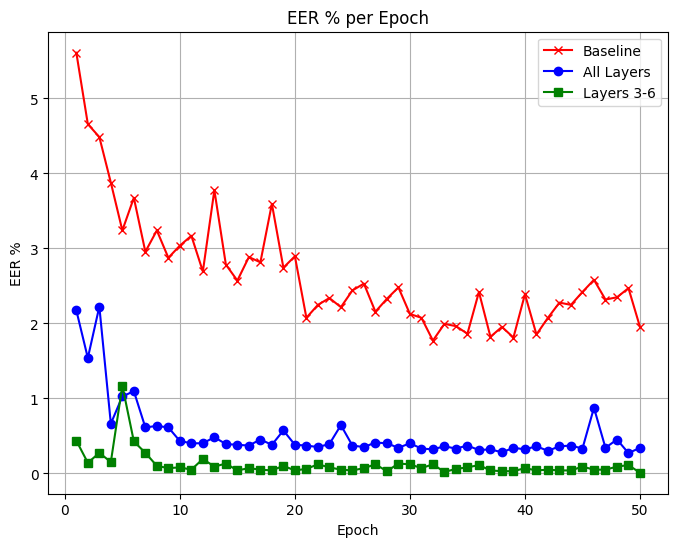

In [38]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 51), [100*eer for eer in eer_base], marker='x', label="Baseline", color='r')
plt.plot(range(1, 51), [100*eer for eer in eer_all], marker='o', label="All Layers", color='b')
plt.plot(range(1, 51), [100*eer for eer in eer_opt], marker='s', label="Layers 3-6", color='g')
plt.xlabel("Epoch")
plt.ylabel("EER %")
plt.title("EER % per Epoch")
plt.legend()
plt.grid(True)
plt.show()